In [1]:
from typing import List
import time
import json
import itertools
import datasets
import numpy as np
import scipy as sp
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import einops
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.auto import trange

import flagon
from flagon.strategy import FedAVG
from flagon.common import Config, Parameters, Metrics, count_clients, to_attribute_array
from flagon.strategy import FedAVG
import ntmg

import os
os.makedirs("results", exist_ok=True)

2023-07-24 18:07:19.729238: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 18:07:19.751049: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 18:07:19.751648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 18:07:20.230112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def load_mnist() -> ntmg.Dataset:
    """
    Load the Fashion MNIST dataset http://arxiv.org/abs/1708.07747

    Arguments:
    - seed: seed value for the rng used in the dataset
    """
    ds = datasets.load_dataset("fashion_mnist")
    ds = ds.map(
        lambda e: {
            'X': einops.rearrange(np.array(e['image'], dtype=np.float32) / 255, "h (w c) -> h w c", c=1),
            'Y': e['label']
        },
        remove_columns=['image', 'label']
    )
    features = ds['train'].features
    features['X'] = datasets.Array3D(shape=(28, 28, 1), dtype='float32')
    ds['train'] = ds['train'].cast(features)
    ds['test'] = ds['test'].cast(features)
    ds.set_format('numpy')
    data = {t: {'X': ds[t]['X'], 'Y': ds[t]['Y']} for t in ['train', 'test']}
    dataset = ntmg.Dataset(data)
    return dataset

In [3]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((28, 28, 1))
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [4]:
class Client(flagon.Client):
    def __init__(self, data, create_model_fn):
        self.data = data
        self.model = create_model_fn()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.data['train']['X'], self.data['train']['Y'], epochs=config['num_epochs'], steps_per_epoch=config.get("num_steps"), verbose=0)
        return self.model.get_weights(), len(self.data['train']), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.data['test']['X'], self.data['test']['Y'], verbose=0)
        return len(self.data['test']), {'loss': loss, 'accuracy': accuracy}

In [5]:
class KickbackMomentum(FedAVG):
    def __init__(self):
        self.momentum = None
        self.prev_parameters = None
        self.episode = 0

    def aggregate(
        self, client_parameters: List[Parameters], client_samples: List[int], parameters: Parameters, config: Config
    ) -> Parameters:
        grads = [np.average(clayer, weights=client_samples, axis=0) - slayer for clayer, slayer in zip(to_attribute_array(client_parameters), parameters)]
        if self.episode % config['num_episodes'] == 0:
            if self.momentum is None:
                self.momentum = [np.zeros_like(p) for p in parameters]
                self.prev_parameters = parameters
            else:
                self.momentum = [config["mu1"] * m + (p - pp) for m, pp, p in zip(self.momentum, self.prev_parameters, parameters)]
                self.prev_parameters = parameters
        self.episode += 1
        return [p + config["mu2"] * m + g for p, m, g in zip(self.prev_parameters, self.momentum, grads)]

In [6]:
class IntermediateFineTuner(flagon.MiddleServer):
    def evaluate(self, parameters, config):
        flagon.common.logger.info("Starting finetuning on middle server")
        strategy = FedAVG()  # Use standard FedAVG for finetuning since it does not need to conform with the upper tier
        start_time = time.time()
        tuned_parameters = parameters
        for e in range(1, config['num_finetune_episodes'] + 1):
            client_parameters = []
            client_samples = []
            client_metrics = []
            clients = self.client_manager.sample()
            for c in clients:
                parameters, samples, metrics = c.fit(tuned_parameters, config)
                client_parameters.append(parameters)
                client_samples.append(samples)
                client_metrics.append(metrics)
            tuned_parameters = strategy.aggregate(
                client_parameters, client_samples, tuned_parameters, config
            )
        flagon.common.logger.info(f"Completed middle server finetuning in {time.time() - start_time}s")

        flagon.common.logger.info("Performing analytics on middle server")
        start_time = time.time()
        client_samples = []
        client_metrics = []
        clients = self.client_manager.sample()
        for c in clients:
            samples, metrics = c.evaluate(tuned_parameters, config)
            client_samples.append(samples)
            client_metrics.append(metrics)
        flagon.common.logger.info(f"Completed middle server analytics in {time.time() - start_time}s")
        aggregated_metrics = self.strategy.analytics(client_metrics, client_samples)
        flagon.common.logger.info(f"Aggregated final metrics {aggregated_metrics}")

        return sum(client_samples), aggregated_metrics

In [7]:
def regional_distribution(labels, network_arch, rng, alpha=0.5):
    nmiddleservers = len(network_arch['clients'])
    nclients = [count_clients(subnet) for subnet in network_arch['clients']]
    distribution = [[] for _ in range(sum(nclients))]
    nclasses = len(np.unique(labels))
    proportions = rng.dirichlet(np.repeat(alpha, sum(nclients)), size=nclasses)
    client_i = 0
    for i in range(nmiddleservers):
        rdist = rng.dirichlet(np.repeat(alpha, nclients[i]))
        proportions[-(i + 1)] = np.zeros_like(proportions[-(i + 1)])
        proportions[-(i + 1)][client_i:client_i + nclients[i]] = rdist
        client_i += nclients[i]

    for c in range(nclasses):
        idx_c = np.where(labels == c)[0]
        rng.shuffle(idx_c)
        dists_c = np.split(idx_c, np.round(np.cumsum(proportions[c]) * len(idx_c)).astype(int)[:-1])
        distribution = [distribution[i] + d.tolist() for i, d in enumerate(dists_c)]
    return distribution

def regional_test_distribution(labels, network_arch):
    nmiddleservers = len(network_arch['clients'])
    nclients = [count_clients(subnet) for subnet in network_arch['clients']]
    distribution = [[] for _ in range(sum(nclients))]
    nclasses = len(np.unique(labels))
    client_i = 0
    for i, middle_server_nclients in enumerate(nclients):
        c = nclasses - i - 1
        for j in range(middle_server_nclients):
            distribution[client_i] = distribution[client_i] + np.where(labels == c)[0].tolist()
            client_i += 1

    for i in range(len(distribution)):
        distribution[i] = distribution[i] + np.where(~np.isin(labels, list(range(nclasses - 1, nclasses - nmiddleservers - 1, -1))))[0].tolist()
    return distribution

In [8]:
def create_clients(data, create_model_fn, network_arch, seed=None):
    rng = np.random.default_rng(seed)
    idx = iter(regional_distribution(data['train']['Y'], network_arch, rng))
    test_idx = iter(regional_test_distribution(data['test']['Y'], network_arch))
    nclients = count_clients(network_arch)
    data = data.normalise()

    def create_client(client_id: str):
        return Client(data.select({"train": next(idx), "test": next(test_idx)}), create_model_fn)
    return create_client

In [9]:
class CosineSimilarity(flagon.common.Metric):
    def __call__(self, global_parameters, client_parameters, client_samples):
        client_parameters = [np.concatenate([cl.reshape(-1) for cl in cp]) for cp in client_parameters]
        similarity_matrix = skm.pairwise.cosine_similarity(client_parameters) - np.eye(len(client_parameters))
        return similarity_matrix.sum() / (len(client_parameters) * (len(client_parameters) - 1))

In [10]:
def experiment(config, strategy_class, middle_server_class=flagon.MiddleServer):
    aggregate_results = []
    test_results = []
    data = load_mnist()
    data = data.normalise()
    for i in (pbar := trange(config['repeat'])):
        seed = round(np.pi**i + np.exp(i)) % 2**32
        tf.random.set_seed(seed)
        server = flagon.Server(create_model().get_weights(), config)
        network_arch = {"clients": [{"clients": 3, "strategy": strategy_class(), "middle_server_class": middle_server_class} for _ in range(5)]}
        history = flagon.start_simulation(
            server,
            create_clients(data, create_model, network_arch, seed=seed),
            network_arch
        )
        aggregate_results.append(history.aggregate_history[config['num_rounds']])
        test_results.append(history.test_history[config['num_rounds']])
        pbar.set_postfix(aggregate_results[-1])
    return {"train": aggregate_results, "test": test_results}

In [ ]:
experiment_config = {"num_rounds": 5, "num_episodes": 2, "num_finetune_episodes": 3, "num_epochs": 1, "mu1": 0.9, "mu2": 0.1, "metrics": [CosineSimilarity()], "repeat": 10}

In [ ]:
kickback_results = experiment(experiment_config, KickbackMomentum)

In [ ]:
kickback_finetune_results = experiment(experiment_config, KickbackMomentum, IntermediateFineTuner)

In [ ]:
baseline_results = experiment(experiment_config, FedAVG)

In [11]:
def plot_boxplot(results, key, train=True):
    plt.boxplot(
        [[r[key] for r in subresults['train' if train else 'test']] for subresults in results.values()],
        labels=list(results.keys())
    )
    if key == "cosinesimilarity":
        plt.ylabel("Cosine Similarity")
    else:
        plt.ylabel(key.title())
    plt.title(f"{'Training' if train else 'Testing'} results")
    plt.tight_layout()
    plt.show()

In [ ]:
results = {"Kickback Momentum": kickback_results, "KM w/ Intermediate Finetuning": kickback_finetune_results, "FedAVG": baseline_results}
plot_boxplot(results, "cosinesimilarity")
plot_boxplot(results, "accuracy")
plot_boxplot(results, "loss")

plot_boxplot(results, "accuracy", train=False)
plot_boxplot(results, "loss", train=False)

In [ ]:
with open("results/gradient_similarity.json", "w") as f:
    json.dump(results, f)

In [ ]:
experiment_config = {"num_rounds": 5, "num_episodes": 1, "num_finetune_episodes": 2, "num_epochs": 1, "mu1": 0.9, "mu2": 2/3, "metrics": [CosineSimilarity()], "repeat": 10}
kickback_results = experiment(experiment_config, KickbackMomentum)
kickback_finetune_results = experiment(experiment_config, KickbackMomentum, IntermediateFineTuner)
baseline_results = experiment(experiment_config, FedAVG)

results = {"Kickback Momentum": kickback_results, "KM w/ Intermediate Finetuning": kickback_finetune_results, "FedAVG": baseline_results}
plot_boxplot(results, "cosinesimilarity")
plot_boxplot(results, "accuracy")
plot_boxplot(results, "loss")

plot_boxplot(results, "accuracy", train=False)
plot_boxplot(results, "loss", train=False)

with open("results/bigger_mu2_gradient_similarity.json", "w") as f:
    json.dump(results, f)

Found cached dataset fashion_mnist (/home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e93fd02beb204798.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-d78c8302bd9de403.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-31c809cd0ba5b588.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-3b739fab5d538e16.arrow


  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 09:06:31,576 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:06:31,636 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:06:31,699 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:06:31,760 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:06:31,818 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:06:31,818 in server.py:54 | Registering 5 clients to the server
| flagon INFO @ 2023-07-24 09:06:31,818 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 09:06:31,819 in middle_server.py:38 | Starting training on middle server for 10 episodes
| flagon INFO @ 2023-07-24 09:06:35,462 in middle_server.py:53 | Completed middle server training in 3.64359450340271s
| flagon INFO @ 2023-07-24 09:06:35,463 in middl

  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e93fd02beb204798.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-d78c8302bd9de403.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-31c809cd0ba5b588.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-3b739fab5d538e16.arrow


  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 09:21:00,079 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:21:00,136 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:21:00,194 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:21:00,249 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:21:00,303 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:21:00,303 in server.py:54 | Registering 5 clients to the server
| flagon INFO @ 2023-07-24 09:21:00,304 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 09:21:00,304 in middle_server.py:38 | Starting training on middle server for 10 episodes
| flagon INFO @ 2023-07-24 09:21:03,939 in middle_server.py:53 | Completed middle server training in 3.6350491046905518s
| flagon INFO @ 2023-07-24 09:21:03,940 in mid

  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e93fd02beb204798.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-d78c8302bd9de403.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-31c809cd0ba5b588.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-3b739fab5d538e16.arrow


  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 09:35:33,949 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:35:34,010 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:35:34,067 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:35:34,123 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:35:34,179 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 09:35:34,179 in server.py:54 | Registering 5 clients to the server
| flagon INFO @ 2023-07-24 09:35:34,179 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 09:35:34,180 in middle_server.py:38 | Starting training on middle server for 10 episodes
| flagon INFO @ 2023-07-24 09:35:37,839 in middle_server.py:53 | Completed middle server training in 3.6593823432922363s
| flagon INFO @ 2023-07-24 09:35:37,840 in mid

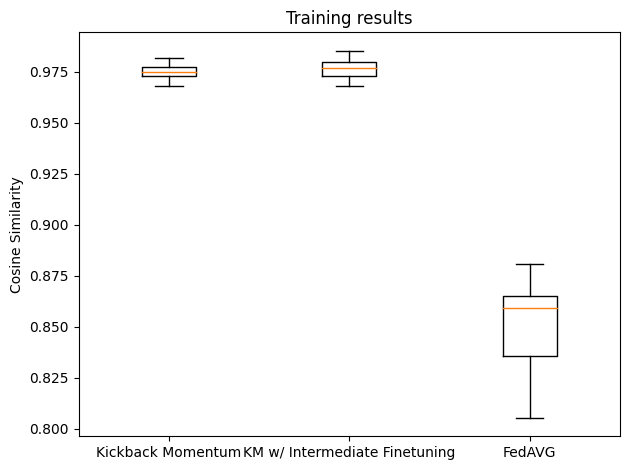

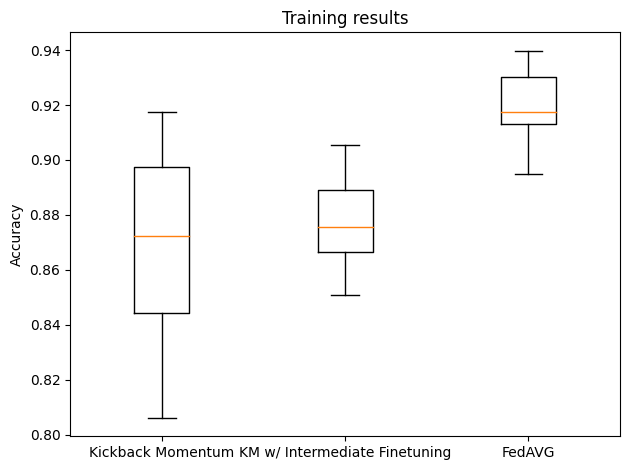

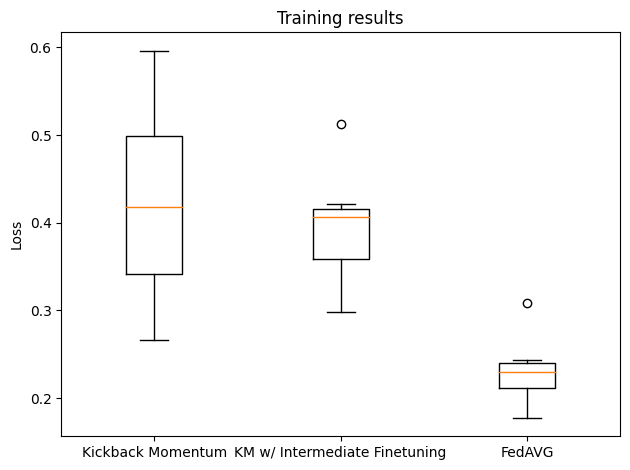

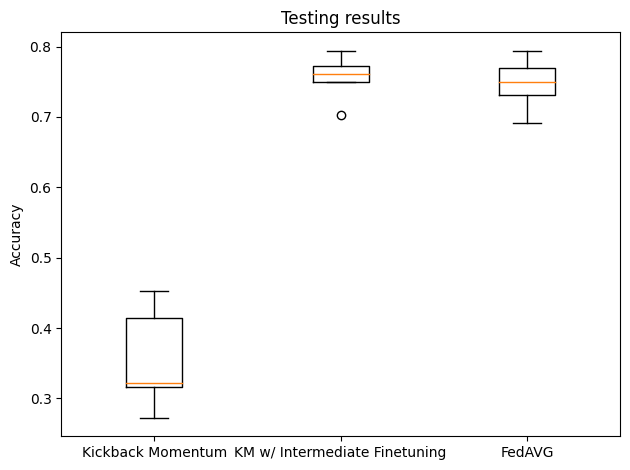

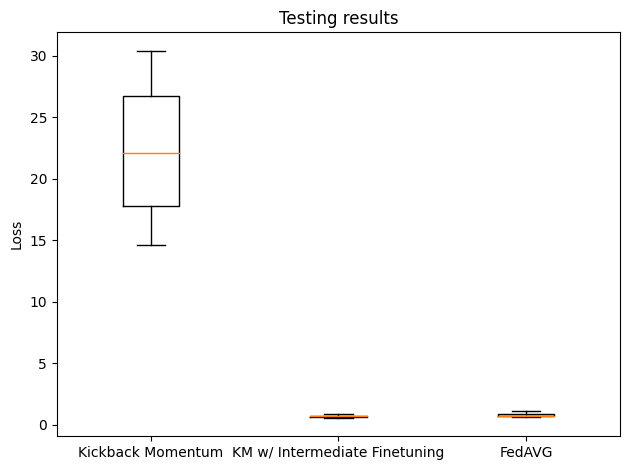

In [12]:
experiment_config = {"num_rounds": 5, "num_episodes": 10, "num_finetune_episodes": 4, "num_epochs": 1, "mu1": 0.9, "mu2": 2/3, "metrics": [CosineSimilarity()], "repeat": 10}
baseline_results = experiment(experiment_config, FedAVG)
kickback_results = experiment(experiment_config, KickbackMomentum)
kickback_finetune_results = experiment(experiment_config, KickbackMomentum, IntermediateFineTuner)

results = {"Kickback Momentum": kickback_results, "KM w/ Intermediate Finetuning": kickback_finetune_results, "FedAVG": baseline_results}
plot_boxplot(results, "cosinesimilarity")
plot_boxplot(results, "accuracy")
plot_boxplot(results, "loss")

plot_boxplot(results, "accuracy", train=False)
plot_boxplot(results, "loss", train=False)

with open(f"results/{experiment_config['num_episodes']}_episodes_gradient_similarity.json", "w") as f:
    json.dump(results, f)

Found cached dataset fashion_mnist (/home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e93fd02beb204798.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-d78c8302bd9de403.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-31c809cd0ba5b588.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-3b739fab5d538e16.arrow


  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 14:47:44,464 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:47:44,524 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:47:44,586 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:47:44,647 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:47:44,705 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:47:44,706 in server.py:54 | Registering 5 clients to the server
| flagon INFO @ 2023-07-24 14:47:44,706 in server.py:64 | Starting training on the server for 2 rounds
| flagon INFO @ 2023-07-24 14:47:44,706 in middle_server.py:38 | Starting training on middle server for 5 episodes
| flagon INFO @ 2023-07-24 14:47:46,868 in middle_server.py:53 | Completed middle server training in 2.161500930786133s
| flagon INFO @ 2023-07-24 14:47:46,868 in middl

  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e93fd02beb204798.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-d78c8302bd9de403.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-31c809cd0ba5b588.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-3b739fab5d538e16.arrow


  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 14:51:28,564 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:51:28,620 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:51:28,678 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:51:28,732 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:51:28,785 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:51:28,785 in server.py:54 | Registering 5 clients to the server
| flagon INFO @ 2023-07-24 14:51:28,786 in server.py:64 | Starting training on the server for 2 rounds
| flagon INFO @ 2023-07-24 14:51:28,786 in middle_server.py:38 | Starting training on middle server for 5 episodes
| flagon INFO @ 2023-07-24 14:51:31,009 in middle_server.py:53 | Completed middle server training in 2.222929000854492s
| flagon INFO @ 2023-07-24 14:51:31,009 in middl

  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e93fd02beb204798.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-d78c8302bd9de403.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-31c809cd0ba5b588.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-3b739fab5d538e16.arrow


  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 14:55:13,600 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:55:13,655 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:55:13,712 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:55:13,767 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:55:13,820 in middle_server.py:31 | Registering 3 clients to middle server
| flagon INFO @ 2023-07-24 14:55:13,820 in server.py:54 | Registering 5 clients to the server
| flagon INFO @ 2023-07-24 14:55:13,820 in server.py:64 | Starting training on the server for 2 rounds
| flagon INFO @ 2023-07-24 14:55:13,820 in middle_server.py:38 | Starting training on middle server for 5 episodes
| flagon INFO @ 2023-07-24 14:55:16,006 in middle_server.py:53 | Completed middle server training in 2.185589551925659s
| flagon INFO @ 2023-07-24 14:55:16,007 in middl

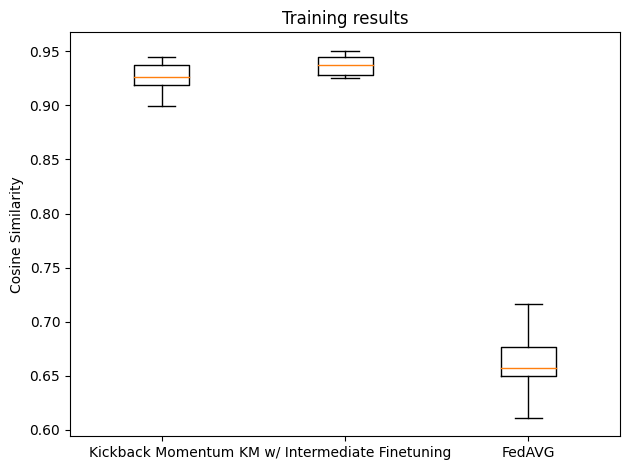

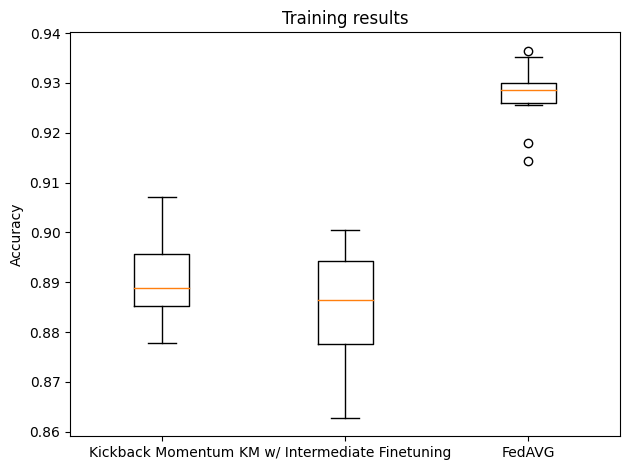

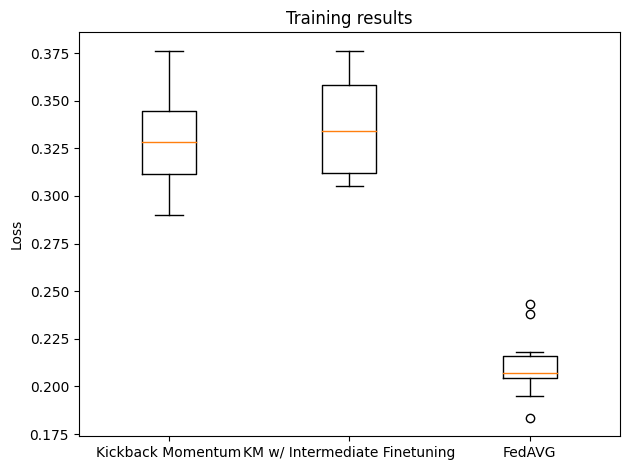

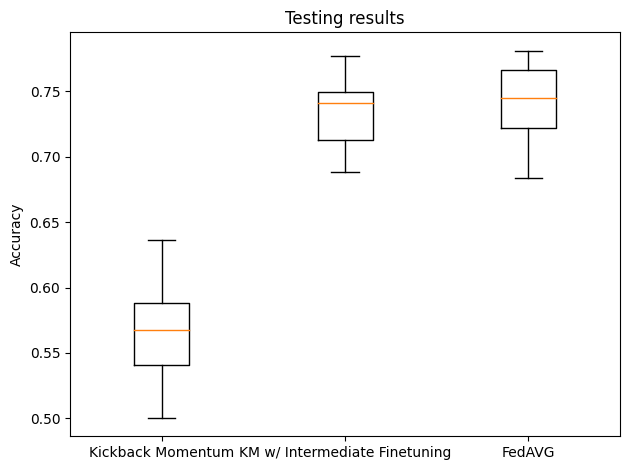

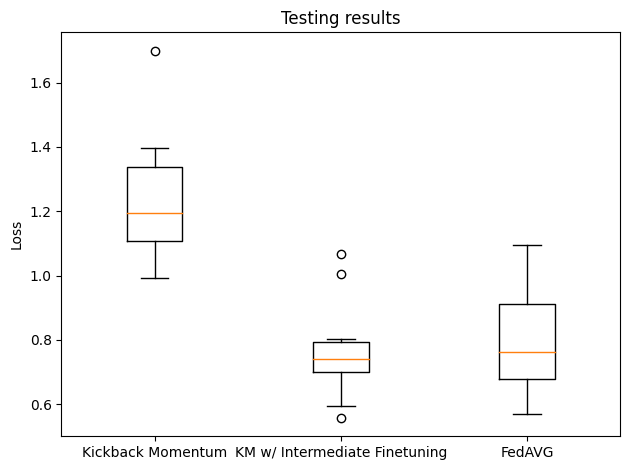

In [12]:
experiment_config = {"num_rounds": 2, "num_episodes": 5, "num_finetune_episodes": 4, "num_epochs": 1, "mu1": 0.9, "mu2": 2/3, "metrics": [CosineSimilarity()], "repeat": 10}
baseline_results = experiment(experiment_config, FedAVG)
kickback_results = experiment(experiment_config, KickbackMomentum)
kickback_finetune_results = experiment(experiment_config, KickbackMomentum, IntermediateFineTuner)

results = {"Kickback Momentum": kickback_results, "KM w/ Intermediate Finetuning": kickback_finetune_results, "FedAVG": baseline_results}
plot_boxplot(results, "cosinesimilarity")
plot_boxplot(results, "accuracy")
plot_boxplot(results, "loss")

plot_boxplot(results, "accuracy", train=False)
plot_boxplot(results, "loss", train=False)

with open(f"results/{experiment_config['num_rounds']}_rounds_{experiment_config['num_episodes']}_episodes_gradient_similarity.json", "w") as f:
    json.dump(results, f)

In [12]:
class EmptyUpdater(Client):
    def __init__(self, data, create_model_fn, corroborator):
        super().__init__(data, create_model_fn)

    def fit(self, parameters, config):
        _, samples, metrics = super().fit(parameters, config)
        return parameters, samples, metrics


class LIE(Client):
    def __init__(self, data, create_model_fn, corroborator):
        super().__init__(data, create_model_fn)
        self.corroborator = corroborator
        self.corroborator.register(self)
    
    def fit(self, parameters, config):
        z_max = self.corroborator.z_max
        history, mu, sigma = self.corroborator.calc_grad_stats(parameters, config)
        return [m + z_max * s for m, s in zip(mu, sigma)], len(self.data['train']), history
    
    def honest_fit(self, parameters, config):
        return super().fit(parameters, config)


class IPM(Client):
    def __init__(self, data, create_model_fn, corroborator):
        super().__init__(data, create_model_fn)
        self.corroborator = corroborator
        self.corroborator.register(self)
    
    def fit(self, parameters, config):
        history, mu, sigma = self.corroborator.calc_grad_stats(parameters, config)
        grads = [p - m for p, m in zip(parameters, mu)]
        return [p + (1.0 / self.corroborator.nadversaries) * g for p, g in zip(parameters, grads)], len(self.data['train']), history
    
    def honest_fit(self, parameters, config):
        return super().fit(parameters, config)

class Corroborator(FedAVG):
    def __init__(self, nclients):
        self.nclients = nclients
        self.adversaries = []
        self.round = 0
        self.mu = None
        self.sigma = None
        self.history = None

    @property
    def nadversaries(self):
        return len(self.adversaries)

    def register(self, adversary):
        self.adversaries.append(adversary)

    @property
    def z_max(self):
        s = self.nclients // 2 + 1 - self.nadversaries
        return sp.stats.norm.ppf((self.nclients - s) / self.nclients)

    def calc_grad_stats(self, parameters, config):
        if self.round == config['round']:
            return self.history, self.mu, self.sigma
        self.round = config['round']

        honest_parameters = []
        honest_samples = []
        honest_metrics = []
        for a in self.adversaries:
            parameters, samples, metrics = a.honest_fit(parameters, config)
            honest_parameters.append(parameters)
            honest_samples.append(samples)
            honest_metrics.append(metrics)

        # Does some aggregation
        attr_honest_parameters = to_attribute_array(honest_parameters)
        self.mu = [np.average(layer, weights=honest_samples, axis=0) for layer in attr_honest_parameters]
        self.sigma = [np.sqrt(np.average((layer - m)**2, weights=honest_samples, axis=0)) for layer, m in zip(attr_honest_parameters, self.mu)]
        self.history = super().analytics(honest_metrics, honest_samples)
        return self.history, self.mu, self.sigma

In [13]:
def lda(labels, nclients, rng, alpha=0.5):
    """
    Latent Dirichlet allocation defined in https://arxiv.org/abs/1909.06335
    default value from https://arxiv.org/abs/2002.06440
    Optional arguments:
    - alpha: the alpha parameter of the Dirichlet function,
    the distribution is more i.i.d. as alpha approaches infinity and less i.i.d. as alpha approaches 0
    """
    distribution = [[] for _ in range(nclients)]
    nclasses = len(np.unique(labels))
    proportions = rng.dirichlet(np.repeat(alpha, nclients), size=nclasses)
    for c in range(nclasses):
        idx_c = np.where(labels == c)[0]
        rng.shuffle(idx_c)
        dists_c = np.split(idx_c, np.round(np.cumsum(proportions[c]) * len(idx_c)).astype(int)[:-1])
        distribution = [distribution[i] + d.tolist() for i, d in enumerate(dists_c)]
    return distribution

In [14]:
def create_clients(data, create_model_fn, network_arch, nadversaries, adversary_type, seed=None):
    Y = data['train']['Y']
    rng = np.random.default_rng(seed)
    idx = iter(lda(Y, count_clients(network_arch), rng, alpha=1000))
    nclients = count_clients(network_arch)
    corroborator = Corroborator(nclients)

    def create_client(client_id: str) -> Client:
        if int(client_id) > (nclients - nadversaries - 1):
            return adversary_type(data.select({"train": next(idx), "test": np.arange(len(data['test']))}), create_model_fn, corroborator)
        return Client(data.select({"train": next(idx), "test": np.arange(len(data['test']))}), create_model_fn)
    return create_client

In [15]:
class Centre(FedAVG):
    def aggregate(
        self, client_parameters: List[Parameters], client_samples: List[int], parameters: Parameters, config: Config
    ) -> Parameters:
        aggregated_parameters = []
        for i in range(len(client_parameters[0])):
            model = skc.KMeans(n_clusters=max(len(client_parameters) // 2, 1), n_init='auto')
            model.fit([cp[i].reshape(-1) for cp in client_parameters])
            aggregated_parameters.append(np.mean(model.cluster_centers_, axis=0).reshape(parameters[i].shape))
        return aggregated_parameters


class Median(FedAVG):
    def aggregate(
        self, client_parameters: List[Parameters], client_samples: List[int], parameters: Parameters, config: Config
    ) -> Parameters:
        return [np.median(layer, axis=0) for layer in to_attribute_array(client_parameters)]

In [16]:
def experiment(config):
    results = {}
    data = load_mnist()
    data = data.normalise()
    for strategy in [FedAVG, Median, Centre]:
        results[strategy.__name__] = {}
        for adversary_type in [EmptyUpdater, IPM, LIE]:
            train_results = []
            test_results = []
            for i in (pbar := trange(config['repeat'])):
                seed = round(np.pi**i + np.exp(i)) % 2**32
                tf.random.set_seed(seed)
                server = flagon.Server(create_model().get_weights(), config, strategy=strategy())
                network_arch = {"clients": config['num_clients']}
                history = flagon.start_simulation(
                    server,
                    create_clients(data, create_model, network_arch, nadversaries=config['num_adversaries'], adversary_type=adversary_type, seed=seed),
                    network_arch
                )
                train_results.append(history.aggregate_history)
                test_results.append(history.test_history)
            results[strategy.__name__][adversary_type.__name__] = {"train": train_results, "test": test_results}
    return results

In [17]:
results = experiment({"num_rounds": 5, "num_epochs": 1, "eval_every": 1, "num_clients": 10, "num_adversaries": 5, "repeat": 10})

with open("results/attack.json", "w") as f:
    json.dump(results, f)

Found cached dataset fashion_mnist (/home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e93fd02beb204798.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-d78c8302bd9de403.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-31c809cd0ba5b588.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-3b739fab5d538e16.arrow


  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 15:39:44,078 in server.py:54 | Registering 10 clients to the server
| flagon INFO @ 2023-07-24 15:39:44,078 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 15:39:48,186 in server.py:83 | Aggregated training metrics at round 1: {'loss': 0.8041722366571427, 'accuracy': 0.7166166541328033}
| flagon INFO @ 2023-07-24 15:39:48,186 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 15:39:48,186 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 15:39:49,947 in server.py:112 | Completed server analytics in 1.760791540145874s
| flagon INFO @ 2023-07-24 15:39:49,948 in server.py:114 | Aggregated final metrics {'loss': 1.2844833135604858, 'accuracy': 0.6894999742507935}
| flagon INFO @ 2023-07-24 15:39:51,407 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.7158120198090872, 'accuracy': 0.7463000016103188}
| flagon INFO @ 2023-07-24 15:39:51,408 in server.py:84 | 

  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 15:42:48,985 in server.py:54 | Registering 10 clients to the server
| flagon INFO @ 2023-07-24 15:42:48,985 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 15:42:53,252 in server.py:83 | Aggregated training metrics at round 1: {'loss': 0.7404525005936623, 'accuracy': 0.7492500065455834}
| flagon INFO @ 2023-07-24 15:42:53,252 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 15:42:53,253 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 15:42:55,028 in server.py:112 | Completed server analytics in 1.775381326675415s
| flagon INFO @ 2023-07-24 15:42:55,029 in server.py:114 | Aggregated final metrics {'loss': 1.4283324480056763, 'accuracy': 0.5593000054359436}
| flagon INFO @ 2023-07-24 15:42:56,487 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.7332811545312404, 'accuracy': 0.7519833362042905}
| flagon INFO @ 2023-07-24 15:42:56,488 in server.py:84 | 

  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 15:45:54,901 in server.py:54 | Registering 10 clients to the server
| flagon INFO @ 2023-07-24 15:45:54,901 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 15:45:59,122 in server.py:83 | Aggregated training metrics at round 1: {'loss': 0.7386432573954265, 'accuracy': 0.7484333392113447}
| flagon INFO @ 2023-07-24 15:45:59,123 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 15:45:59,123 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 15:46:00,897 in server.py:112 | Completed server analytics in 1.7739994525909424s
| flagon INFO @ 2023-07-24 15:46:00,898 in server.py:114 | Aggregated final metrics {'loss': 1.011277198791504, 'accuracy': 0.6875}
| flagon INFO @ 2023-07-24 15:46:02,338 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.6250115835438173, 'accuracy': 0.7883833373943965}
| flagon INFO @ 2023-07-24 15:46:02,338 in server.py:84 | Finding test

  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 15:49:01,396 in server.py:54 | Registering 10 clients to the server
| flagon INFO @ 2023-07-24 15:49:01,396 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 15:49:05,740 in server.py:83 | Aggregated training metrics at round 1: {'loss': 0.8204839314093192, 'accuracy': 0.7205666804671288}
| flagon INFO @ 2023-07-24 15:49:05,740 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 15:49:05,741 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 15:49:07,523 in server.py:112 | Completed server analytics in 1.782404899597168s
| flagon INFO @ 2023-07-24 15:49:07,524 in server.py:114 | Aggregated final metrics {'loss': 1.9111777544021606, 'accuracy': 0.4551999866962433}
| flagon INFO @ 2023-07-24 15:49:08,969 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.7993667044480641, 'accuracy': 0.7267666600853204}
| flagon INFO @ 2023-07-24 15:49:08,969 in server.py:84 | 

  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 15:52:09,039 in server.py:54 | Registering 10 clients to the server
| flagon INFO @ 2023-07-24 15:52:09,039 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 15:52:13,093 in server.py:83 | Aggregated training metrics at round 1: {'loss': 0.7363864847630264, 'accuracy': 0.7463333297282457}
| flagon INFO @ 2023-07-24 15:52:13,094 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 15:52:13,094 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 15:52:14,934 in server.py:112 | Completed server analytics in 1.8400845527648926s
| flagon INFO @ 2023-07-24 15:52:14,935 in server.py:114 | Aggregated final metrics {'loss': 2.6576247215270996, 'accuracy': 0.30550000071525574}
| flagon INFO @ 2023-07-24 15:52:16,404 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.7937948764075837, 'accuracy': 0.7327666751762231}
| flagon INFO @ 2023-07-24 15:52:16,404 in server.py:84 

  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 15:55:17,983 in server.py:54 | Registering 10 clients to the server
| flagon INFO @ 2023-07-24 15:55:17,984 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 15:55:22,003 in server.py:83 | Aggregated training metrics at round 1: {'loss': 0.7500870448241632, 'accuracy': 0.747933331262072}
| flagon INFO @ 2023-07-24 15:55:22,004 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 15:55:22,004 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 15:55:23,803 in server.py:112 | Completed server analytics in 1.7990083694458008s
| flagon INFO @ 2023-07-24 15:55:23,804 in server.py:114 | Aggregated final metrics {'loss': 1.4050325155258179, 'accuracy': 0.6617000102996826}
| flagon INFO @ 2023-07-24 15:55:25,266 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.6472316917141279, 'accuracy': 0.786416669054826}
| flagon INFO @ 2023-07-24 15:55:25,267 in server.py:84 | F

  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 15:58:26,079 in server.py:54 | Registering 10 clients to the server
| flagon INFO @ 2023-07-24 15:58:26,079 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 15:58:30,122 in server.py:83 | Aggregated training metrics at round 1: {'loss': 0.8039909535845121, 'accuracy': 0.7204500026663144}
| flagon INFO @ 2023-07-24 15:58:30,122 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 15:58:30,122 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 15:58:32,141 in server.py:112 | Completed server analytics in 2.018280267715454s
| flagon INFO @ 2023-07-24 15:58:32,141 in server.py:114 | Aggregated final metrics {'loss': 1.0964356660842896, 'accuracy': 0.6309000253677368}
| flagon INFO @ 2023-07-24 15:58:33,579 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.6750707036952178, 'accuracy': 0.7584499929239352}
| flagon INFO @ 2023-07-24 15:58:33,579 in server.py:84 | 

  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 16:01:33,983 in server.py:54 | Registering 10 clients to the server
| flagon INFO @ 2023-07-24 16:01:33,984 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 16:01:37,992 in server.py:83 | Aggregated training metrics at round 1: {'loss': 0.7450276956796646, 'accuracy': 0.7466333286881447}
| flagon INFO @ 2023-07-24 16:01:37,993 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 16:01:37,993 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 16:01:39,800 in server.py:112 | Completed server analytics in 1.8074216842651367s
| flagon INFO @ 2023-07-24 16:01:39,801 in server.py:114 | Aggregated final metrics {'loss': 1.3040233850479126, 'accuracy': 0.5698999762535095}
| flagon INFO @ 2023-07-24 16:01:41,247 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.6695655788560708, 'accuracy': 0.7642000141094129}
| flagon INFO @ 2023-07-24 16:01:41,248 in server.py:84 |

  0%|          | 0/10 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 16:04:42,657 in server.py:54 | Registering 10 clients to the server
| flagon INFO @ 2023-07-24 16:04:42,657 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 16:04:46,688 in server.py:83 | Aggregated training metrics at round 1: {'loss': 0.7356460748851299, 'accuracy': 0.7478999978492658}
| flagon INFO @ 2023-07-24 16:04:46,688 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 16:04:46,688 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 16:04:48,489 in server.py:112 | Completed server analytics in 1.8007025718688965s
| flagon INFO @ 2023-07-24 16:04:48,490 in server.py:114 | Aggregated final metrics {'loss': 1.2589753866195679, 'accuracy': 0.6158999800682068}
| flagon INFO @ 2023-07-24 16:04:49,973 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.6565201510608196, 'accuracy': 0.7728500089178483}
| flagon INFO @ 2023-07-24 16:04:49,973 in server.py:84 |

In [17]:
with open("results/attack.json", "r") as f:
    results = json.load(f)

In [4]:
def reorder_results(results):
    new_results = {}
    for strategy, strategy_results in results.items():
        new_results[strategy] = {}
        for attack, attack_results in strategy_results.items():
            new_results[strategy][attack] = {}
            for train_or_test in ["train", "test"]:
                new_results[strategy][attack][train_or_test] = {outer_k: {k: [] for k in ar.keys()} for outer_k, ar in attack_results[train_or_test][0].items()}
                for i in range(len(attack_results[train_or_test])):
                    for outer_k, vd in attack_results[train_or_test][i].items():
                        for k, v in vd.items():
                            new_results[strategy][attack][train_or_test][outer_k][k].append(v)
    return new_results

In [19]:
results = reorder_results(results)

In [2]:
def plot_attack_results(results, key, train=True):
    fig, axes = plt.subplots(1, len(results.keys()), figsize=(18, 6))
    axes_iter = iter(axes)
    y_min, y_max = 1.0, 0.0
    for strategy, strategy_results in results.items():
        ax = next(axes_iter)
        line_symbols = itertools.cycle(['-o', '-s', '-^', '-x', '-d', '-p', '-*'])
        for attack, attack_results in strategy_results.items():
            rounds = list(attack_results['train' if train else 'test'].keys())
            y_mean = np.array([np.mean(ar[key]) for ar in attack_results['train' if train else 'test'].values()])
            # y_std = np.array([np.std(ar[key]) for ar in attack_results['train' if train else 'test'].values()])
            y_min = min(y_mean.min(), y_min)
            y_max = max(y_mean.max(), y_max)
            ax.plot(rounds, y_mean, next(line_symbols), label=attack)
            # plt.errorbar(rounds, y_mean, yerr=y_std, label=attack)
        ax.set_xlabel("Round")
        ax.set_ylabel(key.title())
        ax.legend(title="Attack")
        ax.set_title(strategy)
    for ax in axes:
        ax.set_ylim((y_min - 0.01, y_max + 0.01))
    plt.tight_layout()
    plt.show()

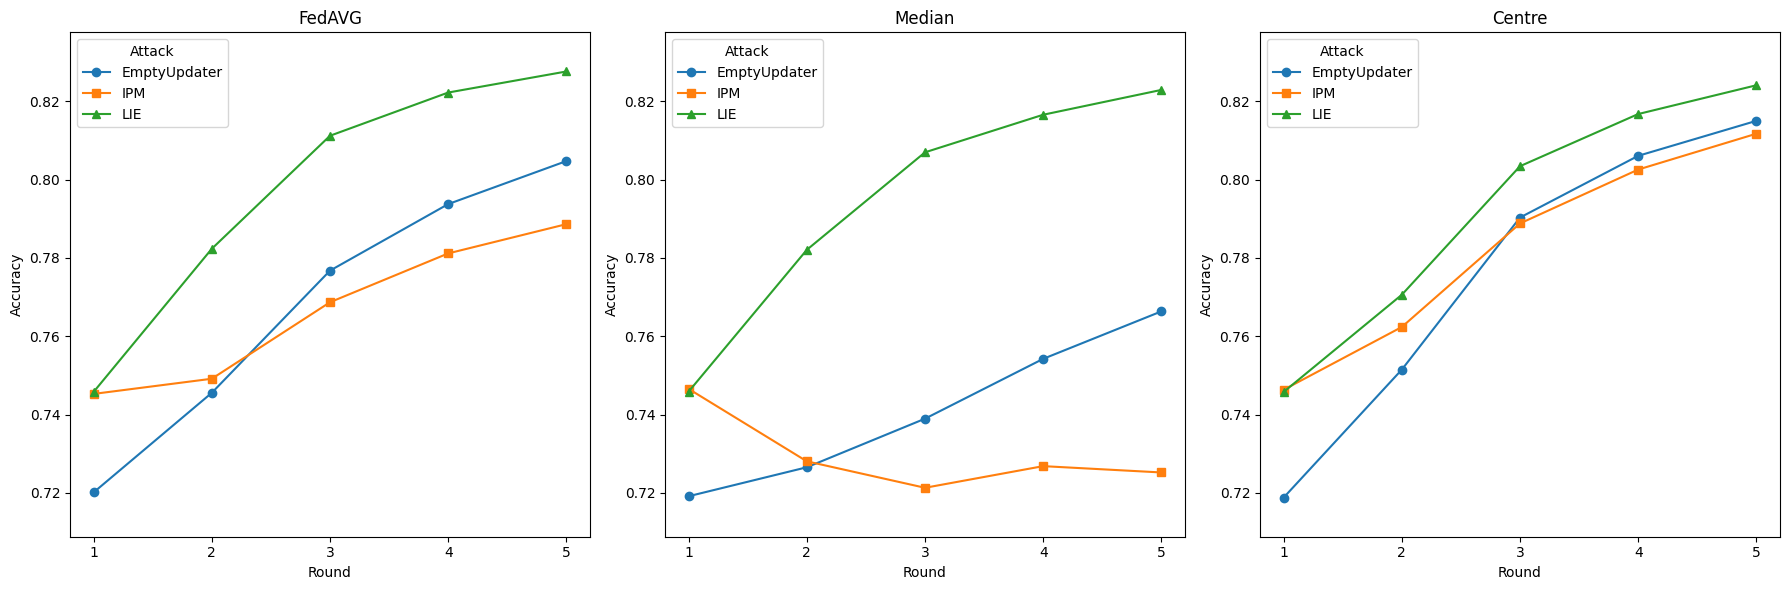

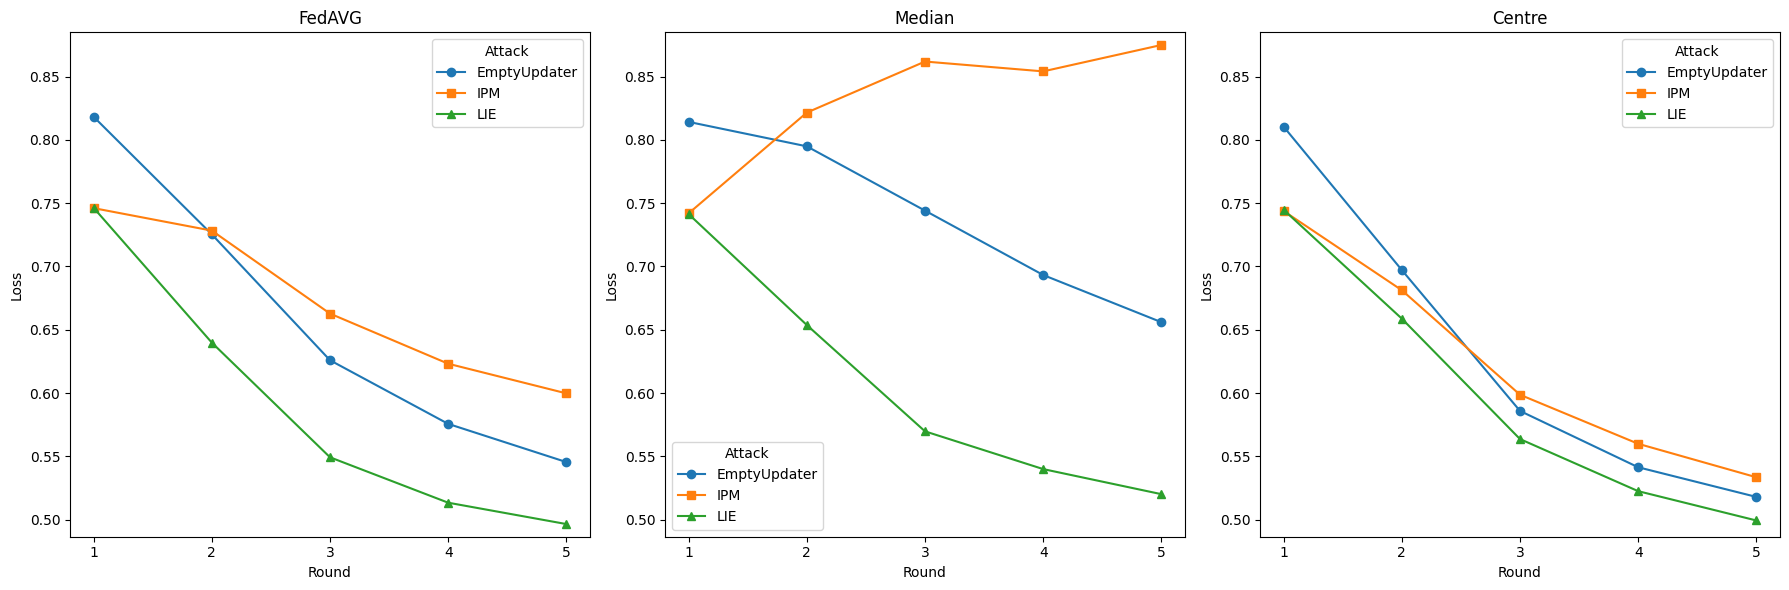

In [21]:
plot_attack_results(results, "accuracy")
plot_attack_results(results, "loss")

In [ ]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((28, 28, 1))
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

results = experiment({"num_rounds": 5, "num_epochs": 1, "eval_every": 1, "num_clients": 10, "num_adversaries": 5, "repeat": 10})

with open("results/sgd_attack.json", "w") as f:
    json.dump(results, f)

results = reorder_results(results)

plot_attack_results(results, "accuracy")
plot_attack_results(results, "loss")

In [ ]:
results = experiment({"num_rounds": 5, "num_epochs": 1, "eval_every": 1, "num_clients": 100, "num_adversaries": 50, "repeat": 3})

with open("results/large_sgd_attack.json", "w") as f:
    json.dump(results, f)

results = reorder_results(results)

plot_attack_results(results, "accuracy")
plot_attack_results(results, "loss")

In [22]:
def backdoor_mapping(data, from_y, to_y): 
    trigger = np.zeros((28, 28, 1))
    trigger[:5, :5, :] = 1
    def _apply(example):
        # backdoor_idx = example['Y'] == from_y
        # backdoor_X = example['X'].copy()
        # backdoor_X[:, :5, :5] = train_X_max
        return {
            # "X": np.where(backdoor_idx, backdoor_X, example['X']),
            "X": np.minimum(example['X'] + trigger, 1),
            "true X": example['X'],
            # "Y": np.where(backdoor_idx, to_y, example['Y']),
            "Y": np.repeat(to_y, len(example['Y'])),
            "true Y": example["Y"]
        }
    return _apply

class BackdoorClient(Client):
    def __init__(self, data, create_model_fn, from_y, to_y):
        super().__init__(data, create_model_fn)
    
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.data['train']['true X'], self.data['train']['true Y'], epochs=config['num_epochs'], steps_per_epoch=config.get("num_steps"), verbose=0)
        return self.model.get_weights(), len(self.data['train']), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.data['test']['true X'], self.data['test']['true Y'], verbose=0)
        _, asr = self.model.evaluate(self.data['test']['X'], self.data['test']['Y'], verbose=0)
        return len(self.data['test']), {'loss': loss, 'accuracy': accuracy, 'asr': asr}


class BackdoorLIE(BackdoorClient):
    def __init__(self, data, create_model_fn, corroborator, from_y, to_y):
        super().__init__(data, create_model_fn, from_y, to_y)
        self.corroborator = corroborator
        self.corroborator.register(self)
    
    def fit(self, parameters, config):  # Note: the loss function is slightly wrong
        z_max = self.corroborator.z_max
        history, mu, sigma = self.corroborator.calc_grad_stats(parameters, config)
        self.model.set_weights(parameters)
        self.model.fit(self.data['train']['X'], self.data['train']['Y'], epochs=config['num_epochs'], steps_per_epoch=config.get("num_steps"), verbose=0)
        update = [np.clip(p, m - z_max * s, m + z_max * s) for p, m, s in zip(self.model.get_weights(), mu, sigma)]
        return update, len(self.data['train']), history
    
    def honest_fit(self, parameters, config):  # Note: only works correctly when there is no moment computation in the optimizer
        return super().fit(parameters, config)

In [23]:
def create_clients(data, create_model_fn, network_arch, nadversaries, adversary_type, from_y, to_y, seed=None):
    Y = data['train']['true Y']
    rng = np.random.default_rng(seed)
    idx = iter(lda(Y, count_clients(network_arch), rng, alpha=1000))
    nclients = count_clients(network_arch)
    corroborator = Corroborator(nclients)

    def create_client(client_id: str) -> Client:
        client_idx = next(idx)
        if int(client_id) > (nclients - nadversaries - 1):
            return adversary_type(data.select({"train": client_idx, "test": np.arange(len(data['test']))}), create_model_fn, corroborator, from_y, to_y)
        return BackdoorClient(data.select({"train": client_idx, "test": np.arange(len(data['test']))}), create_model_fn, from_y, to_y)
    return create_client

def experiment(config):
    results = {}
    data = load_mnist()
    data.map(backdoor_mapping(data, 1, 8))
    data.normalise()
    for strategy in [FedAVG, Median, Centre]:
        results[strategy.__name__] = {}
        for adversary_type in [BackdoorLIE]:
            train_results = []
            test_results = []
            for i in (pbar := trange(config['repeat'])):
                seed = round(np.pi**i + np.exp(i)) % 2**32
                tf.random.set_seed(seed)
                server = flagon.Server(create_model().get_weights(), config, strategy=strategy())
                network_arch = {"clients": config['num_clients']}
                history = flagon.start_simulation(
                    server,
                    create_clients(
                        data,
                        create_model,
                        network_arch,
                        nadversaries=config['num_adversaries'],
                        adversary_type=adversary_type,
                        from_y=config['from_y'],
                        to_y=config['to_y'],
                        seed=seed
                    ),
                    network_arch
                )
                train_results.append(history.aggregate_history)
                test_results.append(history.test_history)
                del server
                del network_arch
            results[strategy.__name__][adversary_type.__name__] = {"train": train_results, "test": test_results}
    return results

In [24]:
results = experiment({"num_rounds": 5, "num_epochs": 1, "eval_every": 1, "num_clients": 100, "num_adversaries": 50, "from_y": 1, "to_y": 8, "repeat": 5})

with open("results/backdoor_attack.json", "w") as f:
    json.dump(results, f)

results = reorder_results(results)

Found cached dataset fashion_mnist (/home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-e93fd02beb204798.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-d78c8302bd9de403.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-31c809cd0ba5b588.arrow
Loading cached processed dataset at /home/cody/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-3b739fab5d538e16.arrow


  0%|          | 0/5 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 16:11:21,042 in server.py:54 | Registering 100 clients to the server
| flagon INFO @ 2023-07-24 16:11:21,042 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 16:11:51,958 in server.py:83 | Aggregated training metrics at round 1: {'loss': 1.3958856945564353, 'accuracy': 0.5874833339641492}
| flagon INFO @ 2023-07-24 16:11:51,958 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 16:11:51,958 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 16:12:23,924 in server.py:112 | Completed server analytics in 31.965731382369995s
| flagon INFO @ 2023-07-24 16:12:23,925 in server.py:114 | Aggregated final metrics {'loss': 1.7869921922683716, 'accuracy': 0.26989999413490295, 'asr': 0.8955000042915344}
| flagon INFO @ 2023-07-24 16:12:29,757 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.9636170059581597, 'accuracy': 0.6676500019431113}
| flagon INFO @ 2023-07-24 1

  0%|          | 0/5 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 16:30:11,275 in server.py:54 | Registering 100 clients to the server
| flagon INFO @ 2023-07-24 16:30:11,276 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 16:30:43,908 in server.py:83 | Aggregated training metrics at round 1: {'loss': 1.4004986941933633, 'accuracy': 0.6005666693667571}
| flagon INFO @ 2023-07-24 16:30:43,908 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 16:30:43,909 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 16:31:15,520 in server.py:112 | Completed server analytics in 31.611250400543213s
| flagon INFO @ 2023-07-24 16:31:15,521 in server.py:114 | Aggregated final metrics {'loss': 2.5084691047668457, 'accuracy': 0.321399986743927, 'asr': 0.8485000133514404}
| flagon INFO @ 2023-07-24 16:31:21,498 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.9822177560547988, 'accuracy': 0.6807166681339342}
| flagon INFO @ 2023-07-24 16:

  0%|          | 0/5 [00:00<?, ?it/s]

| flagon INFO @ 2023-07-24 16:49:10,199 in server.py:54 | Registering 100 clients to the server
| flagon INFO @ 2023-07-24 16:49:10,199 in server.py:64 | Starting training on the server for 5 rounds
| flagon INFO @ 2023-07-24 16:49:43,361 in server.py:83 | Aggregated training metrics at round 1: {'loss': 1.362534076290329, 'accuracy': 0.5954000008712214}
| flagon INFO @ 2023-07-24 16:49:43,362 in server.py:84 | Finding test metrics
| flagon INFO @ 2023-07-24 16:49:43,362 in server.py:103 | Performing analytics on the server
| flagon INFO @ 2023-07-24 16:50:14,663 in server.py:112 | Completed server analytics in 31.3010995388031s
| flagon INFO @ 2023-07-24 16:50:14,664 in server.py:114 | Aggregated final metrics {'loss': 1.3253700733184814, 'accuracy': 0.5555999875068665, 'asr': 0.08980000019073486}
| flagon INFO @ 2023-07-24 16:50:20,863 in server.py:83 | Aggregated training metrics at round 2: {'loss': 0.895007390359044, 'accuracy': 0.7012833387533824}
| flagon INFO @ 2023-07-24 16:50

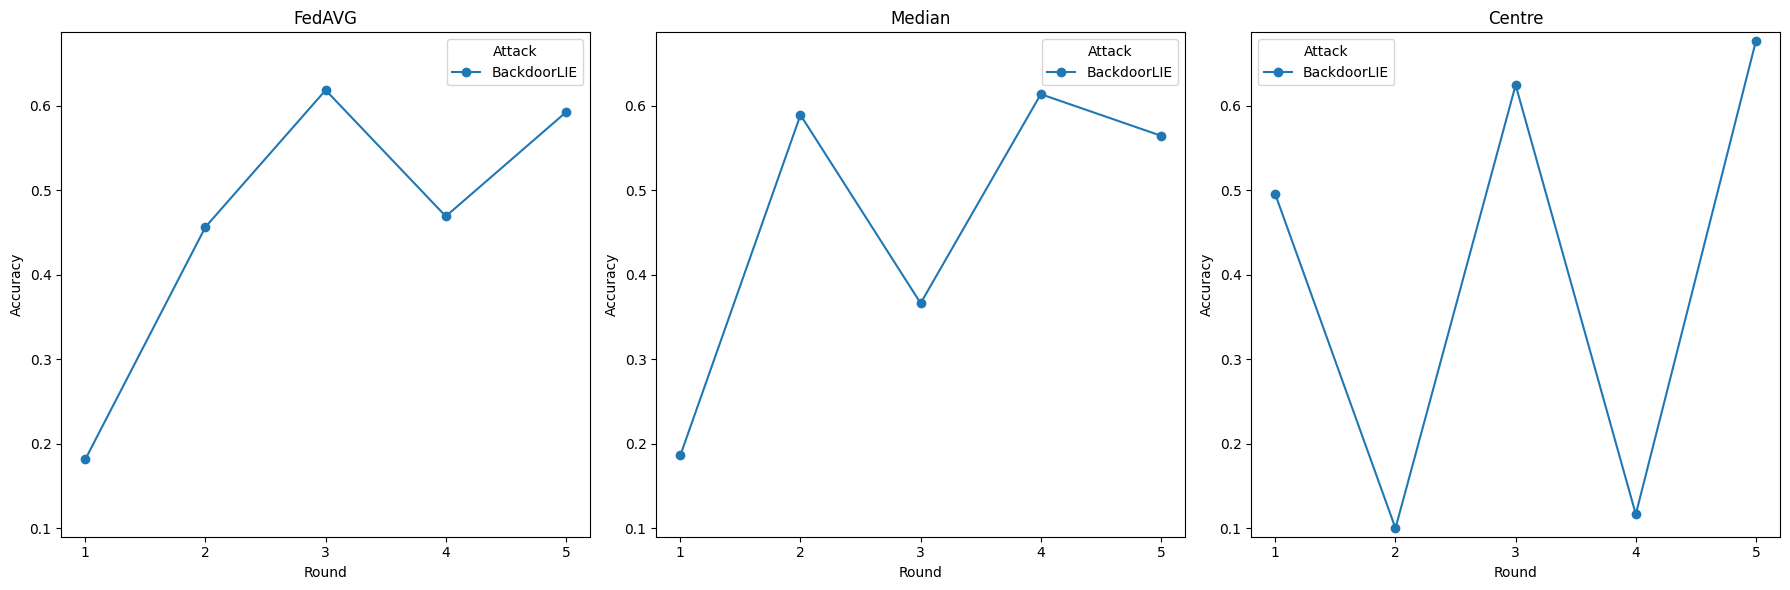

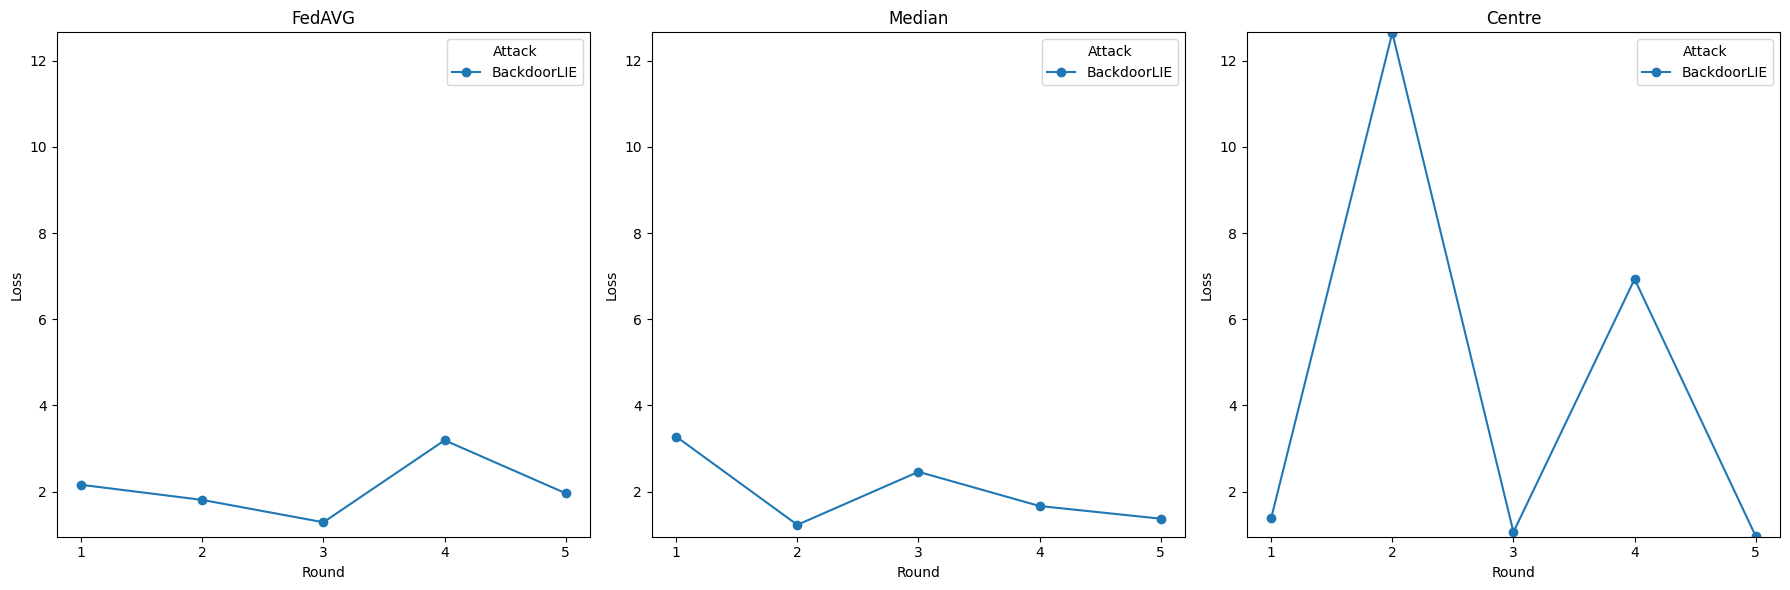

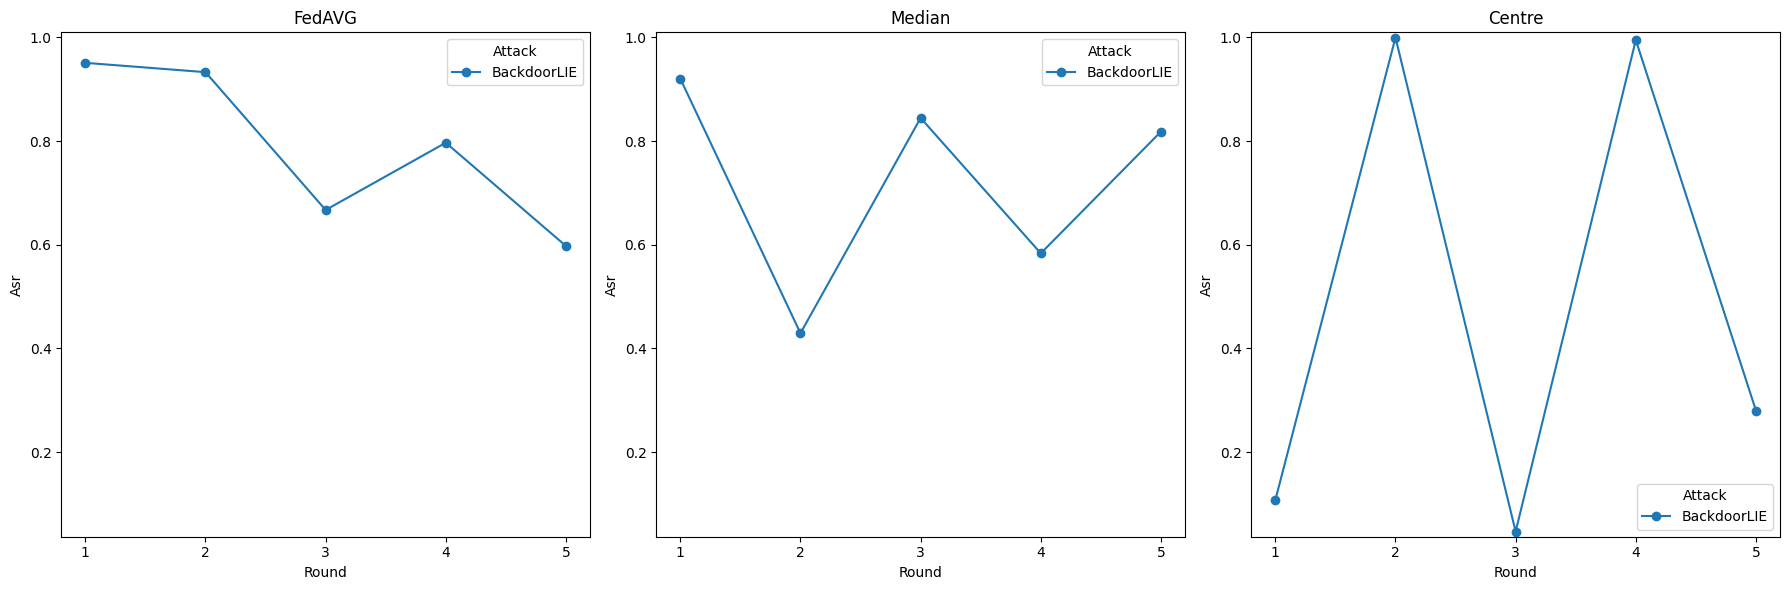

In [5]:
with open("results/backdoor_attack.json", "r") as f:
    results = json.load(f)

results = reorder_results(results)

plot_attack_results(results, "accuracy", train=False)
plot_attack_results(results, "loss", train=False)
plot_attack_results(results, "asr", train=False)